# 机器翻译

### 导入相关库

In [1]:
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import io
import time
import jieba
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

### 指定数据路径

In [2]:
path_to_file = "data/cmn.txt" 
## 数据集文件

### 定义预处理函数

In [3]:
def preprocess_eng(w):
    w = w.lower().strip()
    # 单词和标点之间加空格
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    # 多个空格合并为一个
    w = re.sub(r'[" "]+', " ", w)
    # 除了(a-z, A-Z, ".", "?", "!", ",")这些字符外，全替换成空格
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
    w = w.rstrip().strip()
    # 增加开始结束标志，让模型知道何时停止预测
    w = '<start> ' + w + ' <end>'
    return w
def preprocess_chinese(w):
    w = w.lower().strip()
    w = jieba.cut(w, cut_all=False, HMM=True)
    w = " ".join(list(w)) # 词之间增加空格
    w = '<start> ' + w + ' <end>'
    return w

### 预处理测试

In [4]:
en_sentence = "May I borrow this book?"
chn_sentence = "我可以借这本书吗？"
print(preprocess_eng(en_sentence))
print(preprocess_chinese(chn_sentence))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


<start> may i borrow this book ? <end>


Loading model cost 0.652 seconds.
Prefix dict has been built successfully.


<start> 我 可以 借 这 本书 吗 ？ <end>


### 加载数据集，并进行预处理操作

In [5]:
# 读取数据，每个元素的样式是 [英文, 中文]
def create_dataset(path, num_examples=None):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[w for w in l.split('\t')] for l in lines[:num_examples]]
    word_pairs = [[preprocess_eng(w[0]), preprocess_chinese(w[1])]
                    for w in word_pairs]
    return word_pairs
word_pairs = create_dataset(path_to_file)
# 展示前 20 个数据
word_pairs[:20]

[['<start> hi . <end>', '<start> 嗨 。 <end>'],
 ['<start> hi . <end>', '<start> 你好 。 <end>'],
 ['<start> run . <end>', '<start> 你 用 跑 的 。 <end>'],
 ['<start> wait ! <end>', '<start> 等等 ！ <end>'],
 ['<start> hello ! <end>', '<start> 你好 。 <end>'],
 ['<start> i try . <end>', '<start> 让 我 来 。 <end>'],
 ['<start> i won ! <end>', '<start> 我 赢 了 。 <end>'],
 ['<start> oh no ! <end>', '<start> 不会 吧 。 <end>'],
 ['<start> cheers ! <end>', '<start> 乾杯 ! <end>'],
 ['<start> he ran . <end>', '<start> 他 跑 了 。 <end>'],
 ['<start> hop in . <end>', '<start> 跳进来 。 <end>'],
 ['<start> i lost . <end>', '<start> 我 迷失 了 。 <end>'],
 ['<start> i quit . <end>', '<start> 我 退出 。 <end>'],
 ['<start> i m ok . <end>', '<start> 我 沒事 。 <end>'],
 ['<start> listen . <end>', '<start> 听 着 。 <end>'],
 ['<start> no way ! <end>', '<start> 不 可能 ！ <end>'],
 ['<start> no way ! <end>', '<start> 没门 ！ <end>'],
 ['<start> really ? <end>', '<start> 你 确定 ？ <end>'],
 ['<start> try it . <end>', '<start> 试试 吧 。 <end>'],
 ['<start> we try

In [6]:
en, chn = zip(*create_dataset(path_to_file))
print(en[-1])
print(chn[-1])
# 显示数据大小
print(len(en), len(chn))

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> 如果 一個 人 在 成人 前 沒 有 機會習 得 目標 語言 ， 他 對 該 語言 的 認識 達 到 母語者 程度 的 機會 是 相當 小 的 。 <end>
20403 20403


In [7]:
def max_length(tensor):
    # 取数据中的最大文本长度，用来将所有文本统一成一致的长度，模型才能够正常训练
    return max(len(t) for t in tensor)

def tokenize(lang):
    """
    1. 分词
    2. 转换成 id
    3. padding, 将每个句子统一成相同的长度，长度不足的后面补 0
    """
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    # 生成 词和 id 的映射词典 {word:id}
    lang_tokenizer.fit_on_texts(lang)
    # 将词转换成对应的 id
    text_ids = lang_tokenizer.texts_to_sequences(lang)
    # 统一成相同的长度
    padded_text_ids = tf.keras.preprocessing.sequence.pad_sequences(text_ids,
                                                                padding='post')
    return padded_text_ids, lang_tokenizer

def load_dataset(path, num_examples=None):
    # 加载数据，并做预处理
    # 将中文设置为源语言，英文设置为目标语言
    targ_lang, inp_lang = zip(*create_dataset(path, num_examples))
    input_data, inp_lang_tokenizer = tokenize(inp_lang)
    target_data, targ_lang_tokenizer = tokenize(targ_lang)
    return input_data, target_data, inp_lang_tokenizer, targ_lang_tokenizer

In [8]:
# num_examples 设置训练数据的大小
# num_examples = 10000, 如果num examples = None 则表示不限制大小，所有样本用于训练
num_examples = None
input_data, target_data, inp_lang, targ_lang = load_dataset(
    path_to_file, num_examples)
# 计算中文数据和英文数据中的最大长度
max_length_targ, max_length_inp = max_length(
    target_data), max_length(input_data)
# 分割训练数据和验证数据
input_train, input_val, target_train, target_val = train_test_split(
    input_data, target_data, test_size=0.05)
# 显示训练数据和验证数据的大小
print(len(input_train), len(target_train),
        len(input_val), len(target_val))

19382 19382 1021 1021


In [9]:
## 查看 词和 id 的对应关系
def convert(lang, data):
    for t in data:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))
            
print("输入：源语言：中文， 词和 id 的映射关系")
convert(inp_lang, input_train[0])
print()
print("输出：目标语言：英文， 词和 id 的映射关系")
convert(targ_lang, target_train[0])

输入：源语言：中文， 词和 id 的映射关系
1 ----> <start>
8 ----> 他
82 ----> 昨天
818 ----> 上学
707 ----> 迟到
6 ----> 了
3 ----> 。
2 ----> <end>

输出：目标语言：英文， 词和 id 的映射关系
1 ----> <start>
11 ----> he
26 ----> was
176 ----> late
27 ----> for
90 ----> school
123 ----> yesterday
3 ----> .
2 ----> <end>


### 转换成 tf.data.Dataset

In [10]:
BUFFER_SIZE = len(input_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
# 0 是为 padding 保留的一个特殊 id， 所以要 + 1
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

# 先做 shuffle， 再取 batch
# see https://stackoverflow.com/questions/50437234/tensorflow-dataset-shuffle-then-batch-or-batch-then-shuffle
dataset = tf.data.Dataset.from_tensor_slices(
    (input_train, target_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 32]), TensorShape([64, 38]))

### 定义 Encoder

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        # vacab_size=vocab_inp_size=9394, embedding_dim=256 enc_units=1024 batch_sz=64
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                            return_sequences=True,
                                            return_state=True,
                                            #recurrent_activation='sigmoid',
                                            recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        # x 是训练数据，shape == (batch_size，max_length) -> (64, 46)
        # embedding 后得到每个词的词向量, x shape == (batch_size, max_length, embedding_dim) -> (64, 46, 256)
        x = self.embedding(x)
        # 在 GRU 中，每一个时间步，输出层和隐藏层是相等的
        # output 是所有时间步的输出层输出 shape == (batch_size, max_length, units) -> (64, 46, 1024)
        # state 是最后一个时间步的隐藏层输出, shape == (batch_size, units) -> (64, 1024)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        # 初始化 gru 的隐层参数, shape == (batch_size, units) -> (64,1024)
        return tf.zeros((self.batch_sz, self.enc_units))

In [12]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# encoder 示例输出
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder 输出的维度: (batch size, sequence length, units) {}'.format(
    sample_output.shape))
print('Encoder 隐层的维度: (batch size, units) {}'.format(sample_hidden.shape))
# GRU,在每一个时间步，隐层和输出层是相等的
print(sample_output[-1, -1, :] == sample_hidden[-1, :])

Encoder 输出的维度: (batch size, sequence length, units) (64, 32, 1024)
Encoder 隐层的维度: (batch size, units) (64, 1024)
tf.Tensor([ True  True  True ...  True  True  True], shape=(1024,), dtype=bool)


### 定义 Attention 层

In [13]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        # query shape == (batch_size, hidden size)
        # 扩展时间维度 shape == (batch_size, 1, hidden size)
        # 为了计算后面的 score
        hidden_with_time_axis = tf.expand_dims(query, 1)
        # score shape == (batch_size, max_length, 1)
        # score 维度为 1 是因为应用了 self.V, V 的维度是 1
        # 应用 self.V 前后的维度是 (batch_size, max_length, units) --> (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        # 使用 softmax 得到 attention 的权重， attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector shape == (batch_size, max_length, hidden_size)
        context_vector = attention_weights * values
        # 相加后的 attention 上下文向量的维度：shape context_vector == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [14]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(
    sample_hidden, sample_output)
print("Attention 输出的维度: (batch size, units) {}".format(attention_result.shape))
print("Attention 权值参数的维度: (batch_size, sequence_length, 1) {}".format(
attention_weights.shape))

Attention 输出的维度: (batch size, units) (64, 1024)
Attention 权值参数的维度: (batch_size, sequence_length, 1) (64, 32, 1)


### 定义 Decoder

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        # vocab_size=vocab_tar_size=6082, embedding_dim=256, dec_units=1024, batch_sz=64
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                            return_sequences=True,
                                            return_state=True,
                                            recurrent_initializer='glorot_uniform')
        # 输出的维度是目标语言词汇表的大小，返回的是 softmax 概率，词汇表中每一个词的概率
        self.fc = tf.keras.layers.Dense(vocab_size)
        # attention
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # This function outputs a result at each timestamp
        # 计算 decoder 的第一个隐状态和 encoder 所有输入之间的 attention 权重， 得到上下文向量,context_vector
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # embedding 后的维度 == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # 把上下文向量 context_vector 和 输入 embedding 拼接在一起
        # context_vector shape == (batch_size, units) -> (64, 1024)
        # 拼接后的数据维度 == (batch_size, 1, embedding_dim + hidden_size) -> (64, 1, 1024 + 256)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # 把拼接后的向量输入 gru
        # 得到当前时间步的输出和隐状态
        # output shape == (batch_size, 1, units) -> (64, 1, 1024), state shape == (batch_size, units) -> (64,1024)
        output, state = self.gru(x)
        # output shape == (batch_size, hidden_size=1024)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size, vocab) -> (64, 6082)
        x = self.fc(output)
        return x, state, attention_weights

In [16]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                        sample_hidden, sample_output)
print('Decoder 输出的维度: (batch_size, vocab size) {}'.format(
sample_decoder_output.shape))

Decoder 输出的维度: (batch_size, vocab size) (64, 6095)


### 定义优化器和损失

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    """Calculate the loss value
    Args:
        real: the true label shape == (batch_size,) -> (64,)
        pred: the probability of each word from the vocabulary, is the output from the decoder 
                shape == (batch_size, vocab_size) -> (64, 6082)
    Returns:
        the average loss of the data in a batch size
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

### 设置 checkpoint 保存路径

In [18]:
checkpoint_dir = 'checkpoints/chinese-eng'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                    encoder=encoder,
                                    decoder=decoder)

### 训练模型

In [19]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        # feed the <start> as the first input of the decoder
        # dec input shape == (batch_size, 1) -> (64, 1)
        dec_input = tf.expand_dims(
            [targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # Teacher forcing - feeding the target as the next input
        # because of the data preprocessing(add a start token to the sentence)
        # the first word is <start>, so t starts from 1(not 0)
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(
                dec_input, dec_hidden, enc_output)
            # targ[:, t] is the true label(index of the word) of every sentence(in a batch) at the currenttimestamp
            # like [ 85 18 25 25 ··· 1047 79 13], shape == (batch_size,) -> (64,)
            # predictions shape == (batch_size, vocab_size) -> (64, 6082)
            loss += loss_function(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    # collect all trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables
    # calculate the gradients for the whole variables
    gradients = tape.gradient(loss, variables)
    # apply the gradients on the variables
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [20]:
EPOCHS = 2 # 50 测试需要，设置训练轮数为 2， 实际为保证效果，建议设置为 50

for epoch in range(EPOCHS):
    start = time.time()
    # 获取 gru 的初始状态
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                    batch,
                                                    batch_loss.numpy()))
    
    # 每两个迭代保存一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                            total_loss / steps_per_epoch))
print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0463
Epoch 1 Batch 100 Loss 1.0839
Epoch 1 Batch 200 Loss 1.0337
Epoch 1 Batch 300 Loss 0.8669
Epoch 1 Loss 1.0609
Epoch 2 Batch 0 Loss 0.8485
Epoch 2 Batch 100 Loss 0.8291
Epoch 2 Batch 200 Loss 0.8267
Epoch 2 Batch 300 Loss 0.7402
Epoch 2 Loss 0.8145
Time taken for 1 epoch 2461.55344748497 sec



### 定义测试和可视化函数

In [21]:
def evaluate(sentence):
    """Translate a sentence
    
    Args:
        sentence: the test sentence 
    """
    
    # max_length_targ 38, max_length_inp 64
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_chinese(sentence)
    # convert each word to the index in the test sentence
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=max_length_inp,
                                                            padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    # hidden shape == (1, 1024)
    hidden = [tf.zeros((1, units))]
    # enc out shape == (1, max_length_inp, 1024) -> (1, 46, 1024)
    # enc hidden shape == (1, 1024)
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        # print(attention_weights)
        # get the index which has the highest probability
        predicted_id = tf.argmax(predictions[0]).numpy()
        # convert the index to the word
        result += targ_lang.index_word[predicted_id] + ' '
        # when the decoder predicts the end, stop prediction
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        # the predicted id is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    # maybe you need to change the fname based on your system, so that the Chinese can be displayedin the plot
    # font = FontProperties(fname=r"C:\\WINDOWS\\Fonts\\simsun.ttc", size=14)
    # set the size of the plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    # cmap means color map, viridis means blue-green-yellow
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    # set the x-tick/y-tick labels with list of string labels
    # ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=font)
    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    # ax.set_yticklabels([''] + predicted_sentence, fontproperties=font, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(
        result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### 离线加载模型

In [27]:
checkpoint_dir = 'checkpoints/chinese-eng'
print(tf.train.latest_checkpoint(checkpoint_dir))
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

checkpoints/chinese-eng/ckpt-1


### 单句翻译测试

Input: <start> 我 有 一只 猫 <end>
Predicted translation: i m a car . <end> 


/tmp/ipykernel_6057/1884495568.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
/tmp/ipykernel_6057/1884495568.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


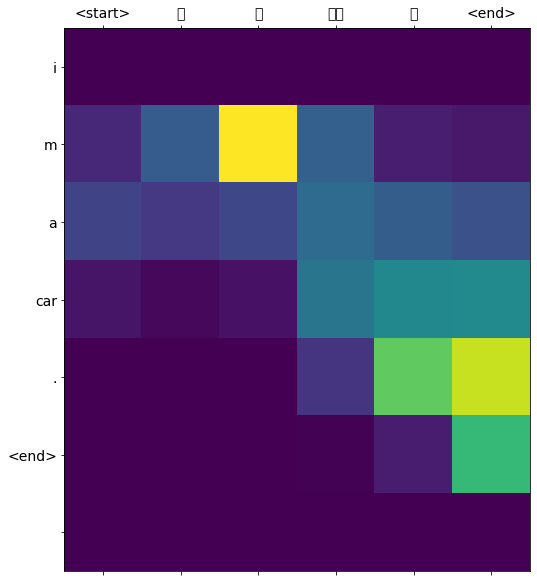

In [28]:
translate('我有一只猫')